In [1]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx
from tqdm import tqdm
%matplotlib notebook

In [54]:
def FG(N,k):

    G = nx.triangular_lattice_graph(N,N)
    #G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    return G

In [3]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

In [4]:
def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

In [5]:


def Properties(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count(G))
    print("L-f: ",len(G.edges())-frustration_count(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))

    print(frustration_count(G)/len(G.edges()))



In [6]:


def Calculate_Probabilites(size,prop):
    probabilites = []
    edges = []
    for i in range(10):
        avg=[]
        for k in tqdm(range(1000)):

            H = FG(size,prop)

            edges.append(len(H.copy().edges()))
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/1000,np.std(total[:,i])/1000))

    return np.array(final)



In [7]:


Properties(FG(5,0.5))



N:  25
L:  40
f:  20
L-f:  20
f+:  10
f-:  10
Delta:  0
Abs(Delta):  0
0.5


In [9]:
probabilites=Calculate_Probabilites(,0.5)
values = probabilites[:,0]
errors = probabilites[:,1]

100%|██████████| 1000/1000 [00:00<00:00, 1977.88it/s]


<IPython.core.display.Javascript object>


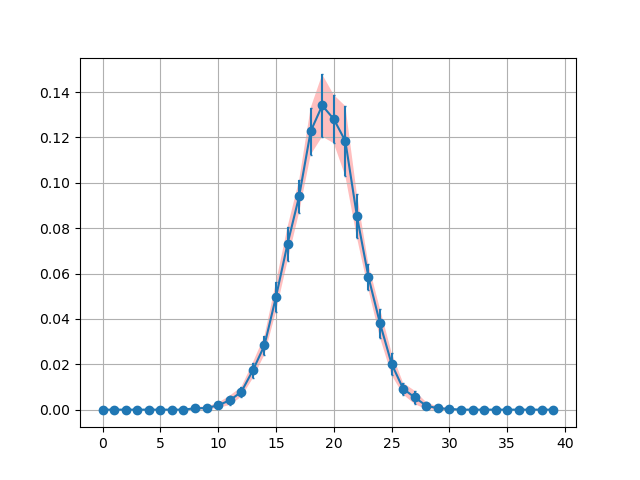

In [11]:


fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=1,marker="o")
ax.scatter([i for i in range(len(values))],values,s=10,marker="x")
ax.grid()



# DELTA

In [17]:
import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

In [48]:
def Calculate_Probabilites2(size,target):
    probabilites = []
    edges = []
    for i in tqdm(range(100)):
        avg=[]
        for k in (range(100)):
            
            H = simulated_annealing(FG(size,0.5),target)

            edges.append(len(H.copy().edges()))
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)
    
    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/100,np.std(total[:,i])/100))

    return np.array(final)

In [101]:


res0 = Calculate_Probabilites2(5,0)



100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


In [97]:
np.save("l40d0.npy",res0)

<IPython.core.display.Javascript object>


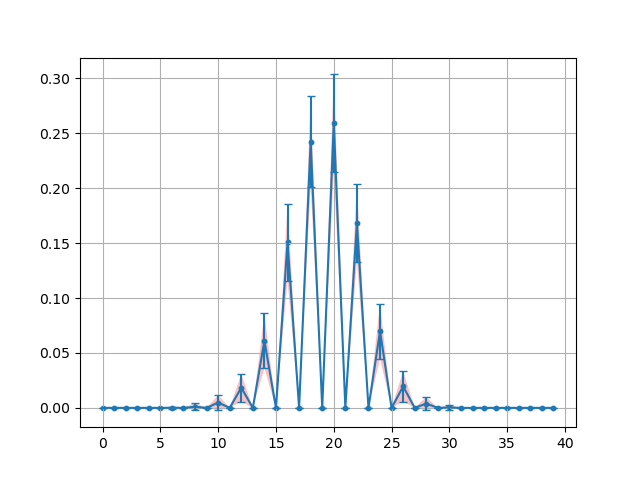

In [50]:
values = res[:,0]
errors = res[:,1]

fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()

In [35]:


F = FG(5,0.5)
Target = 0

G = simulated_annealing(F,Target)

p,n = color_of_frustration(G)
d_final = int(np.sqrt((p-n)**2))
print("d_final =",d_final)

Properties(G)


d_final = 0
N:  25
L:  40
f:  18
L-f:  22
f+:  9
f-:  9
Delta:  0
Abs(Delta):  0
0.45


In [36]:
def Load_Analytic_Solution(filepath):
    f = open(filepath,'r')

    p =[]
    for line in f:
        
        #p.append(float((line.rstrip("\n"))))
        if len(line.rstrip("\n"))==1:
                pappend(0)
        else:
            p.append(float((line.rstrip("\n")).replace("*^","e")))
    p = np.array(p)
    #p = np.delete(p, 0)
    p = np.delete(p, -1)
    
    return p

In [37]:
filepath = "/home/sven/Desktop/l40d0.txt"
p_true = Load_Analytic_Solution(filepath)

<IPython.core.display.Javascript object>


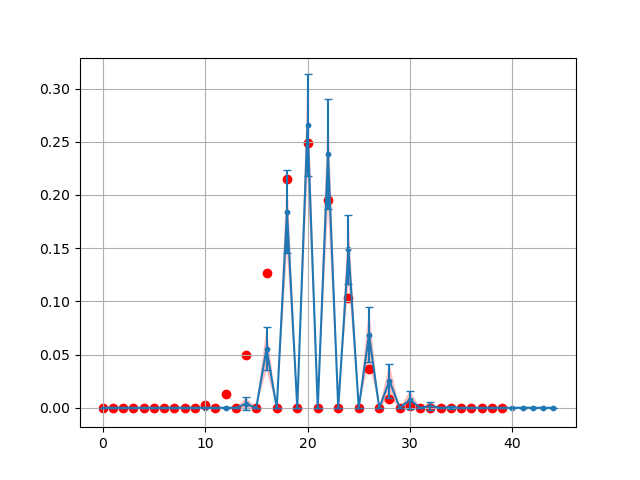

In [99]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.scatter([i for i in range(len(p_true))],p_true,color="red")#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.grid()

<IPython.core.display.Javascript object>


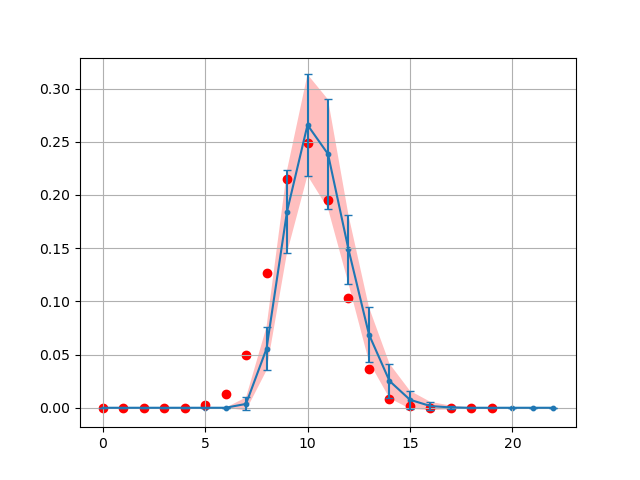

In [100]:

filepath = "/home/sven/Desktop/l40d0.txt"
p_true = Load_Analytic_Solution(filepath)


res0 = np.load("l40d0.npy")

values = res0[:,0]
errors = res0[:,1]

P_even = np.array(values[::2])
P_even_errors =  np.array(errors[::2])

P_true_even = np.array(p_true[::2])


fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(P_even))], P_even - P_even_errors, P_even + P_even_errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(P_even))],P_even,P_even_errors,capsize=3)
ax.scatter([i for i in range(len(P_even))],P_even,s=10)#,marker="x")

ax.scatter([i for i in range(len(P_true_even))],P_true_even,color="red")#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.grid()

# Larger System

In [56]:


F = FG(20,0.5)
Target = 0

G = simulated_annealing(F,Target)

p,n = color_of_frustration(G)
d_final = int(np.sqrt((p-n)**2))
print("d_final =",d_final)

Properties(G)


d_final = 0
N:  231
L:  630
f:  298
L-f:  332
f+:  149
f-:  149
Delta:  0
Abs(Delta):  0
0.473015873015873


In [57]:


res = Calculate_Probabilites2(20,0)



100%|██████████| 100/100 [1:34:40<00:00, 56.80s/it]


In [61]:
np.save("l630d0.npy",res)

<IPython.core.display.Javascript object>


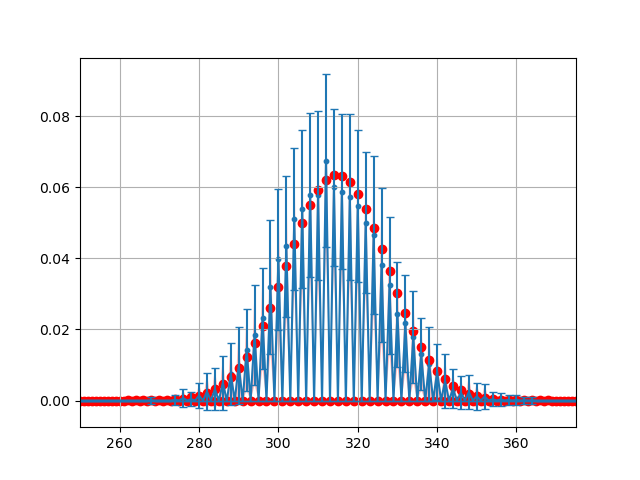

In [63]:
values = res[:,0]
errors = res[:,1]

fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.scatter([i for i in range(len(p_true))],p_true,color="red")#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.set_xlim(250,375)
ax.grid()

In [62]:
filepath = "/home/sven/Desktop/l630d0.txt"
p_true = Load_Analytic_Solution(filepath)

<IPython.core.display.Javascript object>


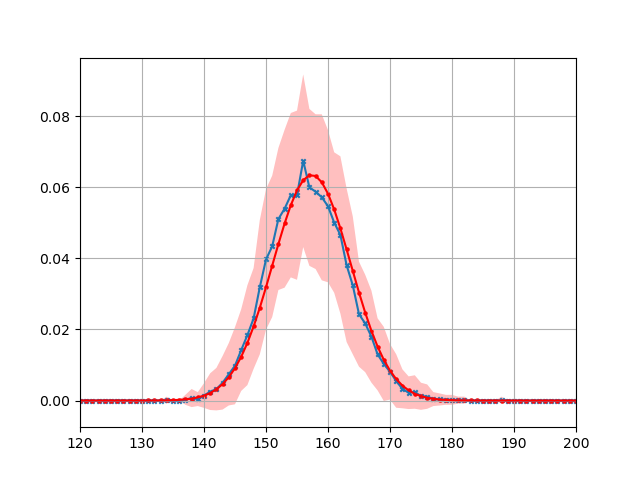

In [95]:
filepath = "/home/sven/Desktop/l630d0.txt"
p_true = Load_Analytic_Solution(filepath)

res = np.load("l630d0.npy")

values = res[:,0]
errors = res[:,1]

P_even = np.array(values[::2])
P_even_errors =  np.array(errors[::2])

P_true_even = np.array(p_true[::2])


fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(P_even))], P_even - P_even_errors, P_even + P_even_errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.plot([i for i in range(len(P_even))],P_even)
ax.scatter([i for i in range(len(P_even))],P_even,s=10,marker="x")#,marker="x")


ax.scatter([i for i in range(len(P_true_even))],P_true_even,color="red",s=5)#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.plot([i for i in range(len(P_true_even))],P_true_even,color="red")#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")


ax.set_xlim(120,200)
ax.grid()

# EVEN LARGER

In [72]:


F = FG(40,0.5)
Target = 0

G = simulated_annealing(F,Target)

p,n = color_of_frustration(G)
d_final = int(np.sqrt((p-n)**2))
print("d_final =",d_final)

Properties(G)


d_final = 0
N:  861
L:  2460
f:  1266
L-f:  1194
f+:  633
f-:  633
Delta:  0
Abs(Delta):  0
0.5146341463414634


In [73]:

res2 = Calculate_Probabilites2(40,0)

100%|██████████| 100/100 [9:35:06<00:00, 345.06s/it] 


In [74]:
np.save("res2.npy",res2)

In [75]:
np.save("l2450d0.npy",res2)

In [76]:
filepath = "/home/sven/Desktop/l2460d0.txt"
p_true = Load_Analytic_Solution(filepath)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sven/Desktop/l2460d0.txt'

<IPython.core.display.Javascript object>


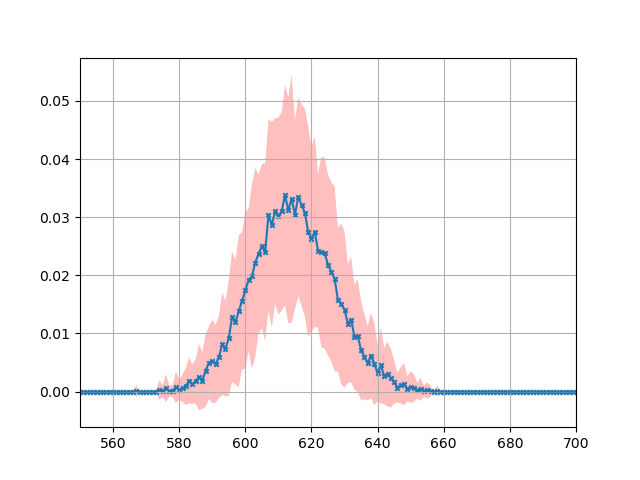

In [82]:
values = res2[:,0]
errors = res2[:,1]

P_even = np.array(values[::2])
P_even_errors =  np.array(errors[::2])

#P_true_even = np.array(p_true[::2])


fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(P_even))], P_even - P_even_errors, P_even + P_even_errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.plot([i for i in range(len(P_even))],P_even)
ax.scatter([i for i in range(len(P_even))],P_even,s=10,marker="x")#,marker="x")

#ax.scatter([i for i in range(len(P_true_even))],P_true_even,color="red",s=5)#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.set_xlim(550,700)
ax.grid()

# LOAD LARGER FILES

In [87]:
def Load_Analytic_Solution_Decimal(filepath):
    f = open(filepath,'r')

    p =[]
    for line in f:
        
        #p.append(float((line.rstrip("\n"))))
        if len(line.rstrip("\n"))==1:
                p.append(0)
        else:
            p.append(float((line.rstrip("\n")).replace("*^","e").replace("`50.","")))
    p = np.array(p)
    #p = np.delete(p, 0)
    p = np.delete(p, -1)
    
    return p

In [88]:

filepath = "/home/sven/Desktop/l2460d0.txt"

p_true = Load_Analytic_Solution_Decimal(filepath)

<IPython.core.display.Javascript object>


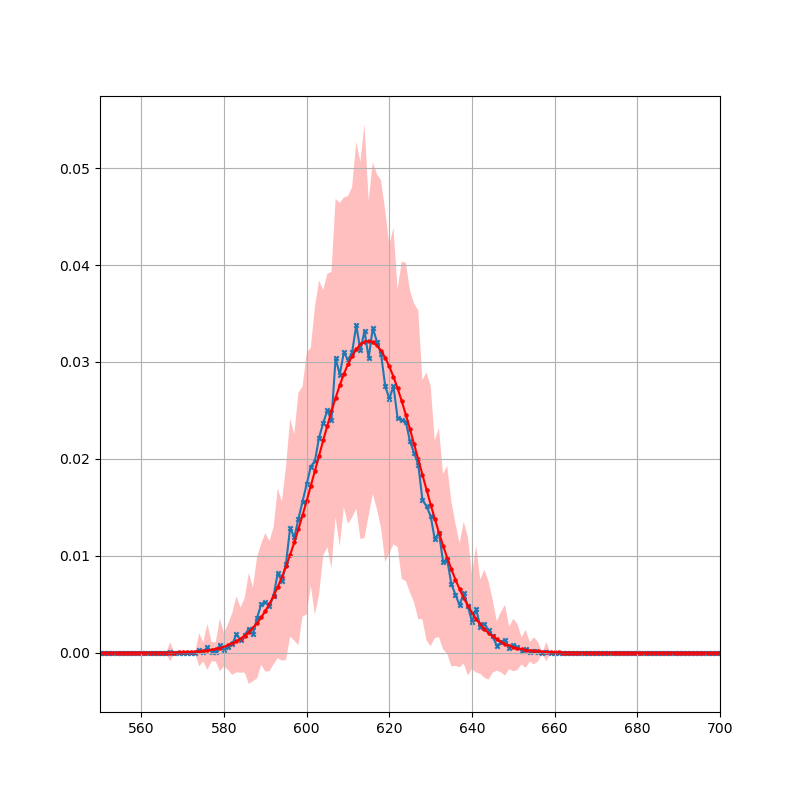

In [91]:
values = res2[:,0]
errors = res2[:,1]

P_even = np.array(values[::2])
P_even_errors =  np.array(errors[::2])

P_true_even = np.array(p_true[::2])


fig, ax = plt.subplots(figsize=[8,8])
ax.fill_between([i for i in range(len(P_even))], P_even - P_even_errors, P_even + P_even_errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.plot([i for i in range(len(P_even))],P_even)
ax.scatter([i for i in range(len(P_even))],P_even,s=10,marker="x")#,marker="x")

ax.scatter([i for i in range(len(P_true_even))],P_true_even,color="red",s=5)#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.plot([i for i in range(len(P_true_even))],P_true_even,color="red")#,marker="x")ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")

ax.set_xlim(550,700)
ax.grid()